In [22]:
import os, sys

sys.path.append('/home/ubuntu/crypto_prediction/git/crypto_prediction_ml_dl/script')

import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from datetime import datetime
from trino_operations import trino_operator
import matplotlib.pyplot as plt
import copy

warnings.filterwarnings("ignore")
trino_ope = trino_operator.Operator()

def create_dataframe_from_hive_mart_table(
    target_schema, target_table, target_columns, target_symbol, column_prefix
):
    """Load data form Hive mart table

        Args:
            target_schema: hive schema name
            target_table: hive table name
            target_columns: column name list to load
            target_symbol: symbol name (e.g., BTC_USDT)
            column_prefix: prefix name for each column

        Returns:
            data frame
    """
    query = f"""
    select
        {target_columns}
    from 
        hive.{target_schema}.{target_table}
    where
        id = '{target_symbol}'
    order by dt
    """

    res = trino_ope.run_query(query)

    indicators_query_result = {}
    for idx, row_data in enumerate(res,1):
        # indicators_query_result[int(idx)] = row_dataa
        indicators_query_result[str(row_data[0])] = row_data # use "dt" as index for the dataframe

    target_columns_list = [
        column_prefix + column.strip() for column in target_columns.strip().split(",")
    ]

    indicators_raw_df = pd.DataFrame.from_dict(
        indicators_query_result, orient="index", columns=target_columns_list
    )

    return indicators_raw_df


def calculate_gain(df, column_prefix: str, col_name: str, past_days: list):
    """ Calculate how much percent gain got from <past_days> days ago.
    
        Args:
            df: data frame including the target column to calculate its gain.
            col_name: column name to get gain percent
            past_days: list of integers, calculate gain percent compared by price between today and <past_day> day ago.
    """
    df_with_gain = copy.deepcopy(df)
    for past_day in past_days:
        new_col_name = f'{column_prefix}p{past_day}_gain'
        past_gain_df = df[col_name].shift(past_day)
        df_with_gain[new_col_name] = (df[col_name] / past_gain_df - 1.0) * 100.0
    return df_with_gain

In [24]:
########################
# Load data from Hive mart
########################
past_days = [1,3,5,7]
target_schema = "crypto_mart"
target_table = "crypto_indicator_day"
target_symbol = "BTC_USDT"
column_prefix = "btc_"
target_columns = """
    dt,
    close,
    volume
    """

btc_raw_df = create_dataframe_from_hive_mart_table(
    target_schema, target_table, target_columns, target_symbol, column_prefix
)
col_name = f'{column_prefix}close'
btc_with_gain_df = calculate_gain(btc_raw_df, column_prefix, col_name, past_days)

target_schema = "forex_mart"
target_table = "forex_indicator_day"
target_symbol = "EURUSD=X"
column_prefix = "eurusd_"
target_columns = """
    dt,
    close,
    volume
    """

eurusd_raw_df = create_dataframe_from_hive_mart_table(
    target_schema, target_table, target_columns, target_symbol, column_prefix
)
col_name = f'{column_prefix}close'
eurusd_with_gain_df = calculate_gain(eurusd_raw_df, column_prefix, col_name, past_days)


target_schema = "stock_mart"
target_table = "stock_index_indicator_day"
target_symbol = "^NDX"
column_prefix = "nasdaq100_"
target_columns = """
    dt,
    close,
    volume
    """

nasdaq100_raw_df = create_dataframe_from_hive_mart_table(
    target_schema, target_table, target_columns, target_symbol, column_prefix
)
col_name = f'{column_prefix}close'
nasdaq100_with_gain_df = calculate_gain(nasdaq100_raw_df, column_prefix, col_name, past_days)


target_schema = "gas_mart"
target_table = "natural_gas_indicator_day"
target_symbol = "NG=F"
column_prefix = "gas_"
target_columns = """
    dt,
    close,
    volume
    """

gas_raw_df = create_dataframe_from_hive_mart_table(
    target_schema, target_table, target_columns, target_symbol, column_prefix
)
col_name = f'{column_prefix}close'
gas_with_gain_df = calculate_gain(gas_raw_df, column_prefix, col_name, past_days)


target_schema = "gold_mart"
target_table = "gold_indicator_day"
target_symbol = "GC=F"
column_prefix = "gold_"
target_columns = """
    dt,
    close,
    volume
    """

gold_raw_df = create_dataframe_from_hive_mart_table(
    target_schema, target_table, target_columns, target_symbol, column_prefix
)
col_name = f'{column_prefix}close'
gold_with_gain_df = calculate_gain(gold_raw_df, column_prefix, col_name, past_days)


target_schema = "oil_mart"
target_table = "crude_oil_indicator_day"
target_symbol = "CL=F"
column_prefix = "oil_"
target_columns = """
    dt,
    close,
    volume
    """

oil_raw_df = create_dataframe_from_hive_mart_table(
    target_schema, target_table, target_columns, target_symbol, column_prefix
)
col_name = f'{column_prefix}close'
oil_with_gain_df = calculate_gain(oil_raw_df, column_prefix, col_name, past_days)


#####################
# merge all dataset #
#####################
all_raw_df = pd.concat([btc_with_gain_df, eurusd_with_gain_df, nasdaq100_with_gain_df, 
                        gas_with_gain_df, gold_with_gain_df, oil_with_gain_df], axis=1, join='outer')
all_raw_df = all_raw_df.sort_index()
all_raw_df.tail()

,btc_dt,btc_close,btc_volume,btc_p1_gain,btc_p3_gain,btc_p5_gain,btc_p7_gain,eurusd_dt,eurusd_close,eurusd_volume,...,gold_p3_gain,gold_p5_gain,gold_p7_gain,oil_dt,oil_close,oil_volume,oil_p1_gain,oil_p3_gain,oil_p5_gain,oil_p7_gain
2023-10-01,2023-10-01,27963.19,28923746.0,3.708183,3.498410,6.653284,6.540725,2023-10-01,1.056524,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-02,2023-10-02,27498.70,55398920.0,-1.661077,2.199550,4.290486,4.543167,2023-10-02,1.048075,0.0,...,-2.222697,-4.518418,-4.647770,2023-10-02,88.82,334493.0,-2.169842,-5.187874,-0.958965,-0.903715
2023-10-03,2023-10-03,27426.56,85231336.0,-0.262340,1.717962,1.512215,4.606545,2023-10-03,1.047230,0.0,...,-1.924317,-3.988634,-5.235276,2023-10-03,89.23,350659.0,0.461608,-2.704176,-1.283328,-0.888593
2023-10-04,2023-10-04,27782.28,68025576.0,1.296991,-0.646958,3.253481,5.365980,2023-10-04,1.047449,0.0,...,-1.601645,-2.837145,-5.118439,2023-10-04,84.22,350659.0,-5.614704,-7.236480,-10.098207,-6.088314
2023-10-05,2023-10-05,27674.80,7801552.0,-0.386865,0.640394,2.638620,2.431010,2023-10-05,1.052521,0.0,...,0.579235,-1.064287,-3.146706,2023-10-05,84.65,9753.0,0.510568,-4.694889,-7.698179,-6.350260


In [25]:
all_raw_df.head()

,btc_dt,btc_close,btc_volume,btc_p1_gain,btc_p3_gain,btc_p5_gain,btc_p7_gain,eurusd_dt,eurusd_close,eurusd_volume,...,gold_p3_gain,gold_p5_gain,gold_p7_gain,oil_dt,oil_close,oil_volume,oil_p1_gain,oil_p3_gain,oil_p5_gain,oil_p7_gain
2009-11-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-11-12,1.485685,0.0,...,NaN,NaN,NaN,2009-11-12,76.94,412833.0,NaN,NaN,NaN,NaN
2009-11-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-11-13,1.490891,0.0,...,NaN,NaN,NaN,2009-11-13,76.35,335366.0,-0.766831,NaN,NaN,NaN
2009-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-11-16,1.498374,0.0,...,NaN,NaN,NaN,2009-11-16,78.90,361387.0,3.339882,NaN,NaN,NaN
2009-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-11-17,1.487697,0.0,...,2.965642,NaN,NaN,2009-11-17,79.14,319240.0,0.304183,2.859371,NaN,NaN
2009-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-11-18,1.495394,0.0,...,2.204104,NaN,NaN,2009-11-18,79.58,253658.0,0.555977,4.230517,NaN,NaN


In [26]:
all_raw_df.shape

(4255, 42)

In [27]:
# Let's use only after 2023-01-01
df = all_raw_df.loc['2023-01-01':]
df.head()

,btc_dt,btc_close,btc_volume,btc_p1_gain,btc_p3_gain,btc_p5_gain,btc_p7_gain,eurusd_dt,eurusd_close,eurusd_volume,...,gold_p3_gain,gold_p5_gain,gold_p7_gain,oil_dt,oil_close,oil_volume,oil_p1_gain,oil_p3_gain,oil_p5_gain,oil_p7_gain
2023-01-01,2023-01-01,16616.42,2256861.0,0.457719,-0.130003,-0.539251,-1.280012,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,2023-01-02,16675.54,3238796.0,0.355793,0.379050,0.458086,-1.441654,2023-01-02,1.070973,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,2023-01-03,16675.31,6038542.0,-0.001379,0.813750,0.223945,-0.186754,2023-01-03,1.067771,0.0,...,1.758947,2.438889,1.310645,2023-01-03,76.93,338520.0,-4.149016,-2.570922,-3.305681,-1.737131
2023-01-04,2023-01-04,16853.53,3843236.5,1.068766,1.426962,1.450468,1.530347,2023-01-04,1.054685,0.0,...,1.830173,2.093895,3.682149,2023-01-04,72.84,352434.0,-5.316522,-7.091837,-8.411920,-6.000774
2023-01-05,2023-01-05,16828.48,3734069.0,-0.148634,0.917152,1.739768,1.144545,2023-01-05,1.060636,0.0,...,0.829807,1.487914,2.166045,2023-01-05,73.67,300731.0,1.139484,-8.210815,-6.699595,-7.403218


In [28]:
df.describe()

,btc_close,btc_volume,btc_p1_gain,btc_p3_gain,btc_p5_gain,btc_p7_gain,eurusd_close,eurusd_volume,eurusd_p1_gain,eurusd_p3_gain,...,gold_p1_gain,gold_p3_gain,gold_p5_gain,gold_p7_gain,oil_close,oil_volume,oil_p1_gain,oil_p3_gain,oil_p5_gain,oil_p7_gain
count,278.000000,2.780000e+02,278.000000,278.000000,278.000000,278.000000,212.000000,212.0,212.000000,212.000000,...,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,26365.638957,2.548777e+07,0.211298,0.638283,1.079703,1.496443,1.082772,0.0,-0.004965,-0.017556,...,0.009390,0.019647,0.045426,0.091147,77.522865,313466.114583,0.048932,0.198898,0.368218,0.588894
std,3283.417478,5.012185e+07,2.299542,4.254715,5.797190,7.126206,0.016183,0.0,0.463908,0.745944,...,0.831946,1.362535,1.781700,2.236665,6.115748,99840.423429,2.059205,3.734645,4.747183,5.517908
min,16616.420000,7.934042e+05,-7.324533,-10.776104,-11.328592,-13.252066,1.047230,0.0,-1.345149,-2.561435,...,-2.786620,-3.451671,-4.518418,-5.235276,66.740000,0.000000,-5.614704,-11.828378,-12.962963,-15.970669
25%,24481.817500,2.454687e+06,-0.771898,-1.307496,-1.944618,-2.043305,1.070761,0.0,-0.288555,-0.542006,...,-0.429299,-0.804475,-1.070872,-1.444331,72.642500,288027.500000,-1.249936,-2.217043,-2.836420,-3.061546
50%,26906.325000,4.002433e+06,-0.049546,0.129481,0.101729,0.083756,1.083893,0.0,-0.002717,-0.127158,...,-0.012782,-0.138680,-0.208244,0.020865,77.105000,324713.000000,0.390979,0.747406,0.873876,0.565901
75%,29061.305000,9.813552e+06,1.193218,1.716837,2.561529,3.337667,1.094736,0.0,0.272995,0.490702,...,0.453524,0.818239,1.110784,1.744872,80.837500,366662.500000,1.289303,2.675023,3.725046,4.127409
max,31449.790000,2.573676e+08,9.642665,20.678697,24.575821,35.825237,1.123760,0.0,1.398635,2.059718,...,2.669173,5.461466,6.283445,8.666630,93.680000,555164.000000,6.277257,10.209675,10.470056,16.531909


In [29]:
# Since tt seems like the "eurusd_volume" is all ZERO, let's drop the column
df = df.drop(['eurusd_volume'], axis=1)
df

,btc_dt,btc_close,btc_volume,btc_p1_gain,btc_p3_gain,btc_p5_gain,btc_p7_gain,eurusd_dt,eurusd_close,eurusd_p1_gain,...,gold_p3_gain,gold_p5_gain,gold_p7_gain,oil_dt,oil_close,oil_volume,oil_p1_gain,oil_p3_gain,oil_p5_gain,oil_p7_gain
2023-01-01,2023-01-01,16616.42,2256861.0,0.457719,-0.130003,-0.539251,-1.280012,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,2023-01-02,16675.54,3238796.0,0.355793,0.379050,0.458086,-1.441654,2023-01-02,1.070973,0.459452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,2023-01-03,16675.31,6038542.0,-0.001379,0.813750,0.223945,-0.186754,2023-01-03,1.067771,-0.298980,...,1.758947,2.438889,1.310645,2023-01-03,76.93,338520.0,-4.149016,-2.570922,-3.305681,-1.737131
2023-01-04,2023-01-04,16853.53,3843236.5,1.068766,1.426962,1.450468,1.530347,2023-01-04,1.054685,-1.225534,...,1.830173,2.093895,3.682149,2023-01-04,72.84,352434.0,-5.316522,-7.091837,-8.411920,-6.000774
2023-01-05,2023-01-05,16828.48,3734069.0,-0.148634,0.917152,1.739768,1.144545,2023-01-05,1.060636,0.564244,...,0.829807,1.487914,2.166045,2023-01-05,73.67,300731.0,1.139484,-8.210815,-6.699595,-7.403218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,2023-10-01,27963.19,28923746.0,3.708183,3.498410,6.653284,6.540725,2023-10-01,1.056524,-0.095099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-02,2023-10-02,27498.70,55398920.0,-1.661077,2.199550,4.290486,4.543167,2023-10-02,1.048075,-0.799679,...,-2.222697,-4.518418,-4.647770,2023-10-02,88.82,334493.0,-2.169842,-5.187874,-0.958965,-0.903715
2023-10-03,2023-10-03,27426.56,85231336.0,-0.262340,1.717962,1.512215,4.606545,2023-10-03,1.047230,-0.080643,...,-1.924317,-3.988634,-5.235276,2023-10-03,89.23,350659.0,0.461608,-2.704176,-1.283328,-0.888593
2023-10-04,2023-10-04,27782.28,68025576.0,1.296991,-0.646958,3.253481,5.365980,2023-10-04,1.047449,0.020960,...,-1.601645,-2.837145,-5.118439,2023-10-04,84.22,350659.0,-5.614704,-7.236480,-10.098207,-6.088314


In [30]:
# And also drop the dt columns for each feature.
df = df.drop(['btc_dt','eurusd_dt','nasdaq100_dt','gas_dt','gold_dt','oil_dt'], axis=1)
df

,btc_close,btc_volume,btc_p1_gain,btc_p3_gain,btc_p5_gain,btc_p7_gain,eurusd_close,eurusd_p1_gain,eurusd_p3_gain,eurusd_p5_gain,...,gold_p1_gain,gold_p3_gain,gold_p5_gain,gold_p7_gain,oil_close,oil_volume,oil_p1_gain,oil_p3_gain,oil_p5_gain,oil_p7_gain
2023-01-01,16616.42,2256861.0,0.457719,-0.130003,-0.539251,-1.280012,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,16675.54,3238796.0,0.355793,0.379050,0.458086,-1.441654,1.070973,0.459452,0.682202,0.393052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,16675.31,6038542.0,-0.001379,0.813750,0.223945,-0.186754,1.067771,-0.298980,0.455940,0.352361,...,1.099082,1.758947,2.438889,1.310645,76.93,338520.0,-4.149016,-2.570922,-3.305681,-1.737131
2023-01-04,16853.53,3843236.5,1.068766,1.426962,1.450468,1.530347,1.054685,-1.225534,-1.068386,-0.849023,...,0.712073,1.830173,2.093895,3.682149,72.84,352434.0,-5.316522,-7.091837,-8.411920,-6.000774
2023-01-05,16828.48,3734069.0,-0.148634,0.917152,1.739768,1.144545,1.060636,0.564244,-0.965187,-0.215312,...,-0.971503,0.829807,1.487914,2.166045,73.67,300731.0,1.139484,-8.210815,-6.699595,-7.403218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,27963.19,28923746.0,3.708183,3.498410,6.653284,6.540725,1.056524,-0.095099,0.570512,-0.249338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-02,27498.70,55398920.0,-1.661077,2.199550,4.290486,4.543167,1.048075,-0.799679,-0.773485,-0.839502,...,-0.979384,-2.222697,-4.518418,-4.647770,88.82,334493.0,-2.169842,-5.187874,-0.958965,-0.903715
2023-10-03,27426.56,85231336.0,-0.262340,1.717962,1.512215,4.606545,1.047230,-0.080643,-0.973940,-0.314184,...,-0.295082,-1.924317,-3.988634,-5.235276,89.23,350659.0,0.461608,-2.704176,-1.283328,-0.888593
2023-10-04,27782.28,68025576.0,1.296991,-0.646958,3.253481,5.365980,1.047449,0.020960,-0.858901,-0.832723,...,-0.334320,-1.601645,-2.837145,-5.118439,84.22,350659.0,-5.614704,-7.236480,-10.098207,-6.088314


In [31]:
# Some columns have NaN values, so let's fill them with near data.
df = df.fillna(method='ffill') # First, fill it with data in most previous date
df = df.fillna(method='bfill') # Second, fill it with data in most future date
df

,btc_close,btc_volume,btc_p1_gain,btc_p3_gain,btc_p5_gain,btc_p7_gain,eurusd_close,eurusd_p1_gain,eurusd_p3_gain,eurusd_p5_gain,...,gold_p1_gain,gold_p3_gain,gold_p5_gain,gold_p7_gain,oil_close,oil_volume,oil_p1_gain,oil_p3_gain,oil_p5_gain,oil_p7_gain
2023-01-01,16616.42,2256861.0,0.457719,-0.130003,-0.539251,-1.280012,1.070973,0.459452,0.682202,0.393052,...,1.099082,1.758947,2.438889,1.310645,76.93,338520.0,-4.149016,-2.570922,-3.305681,-1.737131
2023-01-02,16675.54,3238796.0,0.355793,0.379050,0.458086,-1.441654,1.070973,0.459452,0.682202,0.393052,...,1.099082,1.758947,2.438889,1.310645,76.93,338520.0,-4.149016,-2.570922,-3.305681,-1.737131
2023-01-03,16675.31,6038542.0,-0.001379,0.813750,0.223945,-0.186754,1.067771,-0.298980,0.455940,0.352361,...,1.099082,1.758947,2.438889,1.310645,76.93,338520.0,-4.149016,-2.570922,-3.305681,-1.737131
2023-01-04,16853.53,3843236.5,1.068766,1.426962,1.450468,1.530347,1.054685,-1.225534,-1.068386,-0.849023,...,0.712073,1.830173,2.093895,3.682149,72.84,352434.0,-5.316522,-7.091837,-8.411920,-6.000774
2023-01-05,16828.48,3734069.0,-0.148634,0.917152,1.739768,1.144545,1.060636,0.564244,-0.965187,-0.215312,...,-0.971503,0.829807,1.487914,2.166045,73.67,300731.0,1.139484,-8.210815,-6.699595,-7.403218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,27963.19,28923746.0,3.708183,3.498410,6.653284,6.540725,1.056524,-0.095099,0.570512,-0.249338,...,-0.661148,-2.752052,-4.014750,-5.011308,90.79,355782.0,-1.003162,0.442527,0.844163,0.564909
2023-10-02,27498.70,55398920.0,-1.661077,2.199550,4.290486,4.543167,1.048075,-0.799679,-0.773485,-0.839502,...,-0.979384,-2.222697,-4.518418,-4.647770,88.82,334493.0,-2.169842,-5.187874,-0.958965,-0.903715
2023-10-03,27426.56,85231336.0,-0.262340,1.717962,1.512215,4.606545,1.047230,-0.080643,-0.973940,-0.314184,...,-0.295082,-1.924317,-3.988634,-5.235276,89.23,350659.0,0.461608,-2.704176,-1.283328,-0.888593
2023-10-04,27782.28,68025576.0,1.296991,-0.646958,3.253481,5.365980,1.047449,0.020960,-0.858901,-0.832723,...,-0.334320,-1.601645,-2.837145,-5.118439,84.22,350659.0,-5.614704,-7.236480,-10.098207,-6.088314


In [32]:
df.describe()

,btc_close,btc_volume,btc_p1_gain,btc_p3_gain,btc_p5_gain,btc_p7_gain,eurusd_close,eurusd_p1_gain,eurusd_p3_gain,eurusd_p5_gain,...,gold_p1_gain,gold_p3_gain,gold_p5_gain,gold_p7_gain,oil_close,oil_volume,oil_p1_gain,oil_p3_gain,oil_p5_gain,oil_p7_gain
count,278.000000,2.780000e+02,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,...,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000
mean,26365.638957,2.548777e+07,0.211298,0.638283,1.079703,1.496443,1.082952,0.004043,-0.003123,-0.008174,...,0.025457,0.050670,0.077911,0.095386,77.472986,304768.848921,0.164343,0.243222,0.464587,0.821917
std,3283.417478,5.012185e+07,2.299542,4.254715,5.797190,7.126206,0.016251,0.472720,0.768213,0.948367,...,0.875071,1.358045,1.775409,2.267175,6.068850,101426.720940,1.977534,3.537058,4.773585,5.454950
min,16616.420000,7.934042e+05,-7.324533,-10.776104,-11.328592,-13.252066,1.047230,-1.345149,-2.561435,-2.697176,...,-2.786620,-3.451671,-4.518418,-5.235276,66.740000,0.000000,-5.614704,-11.828378,-12.962963,-15.970669
25%,24481.817500,2.454687e+06,-0.771898,-1.307496,-1.944618,-2.043305,1.070973,-0.305643,-0.597721,-0.687555,...,-0.423092,-0.733549,-1.089558,-1.458006,72.587500,283539.000000,-1.171158,-2.049748,-2.713745,-2.714413
50%,26906.325000,4.002433e+06,-0.049546,0.129481,0.101729,0.083756,1.084334,-0.002717,-0.105802,-0.118885,...,0.012999,-0.129689,-0.120931,0.023962,76.990000,319444.500000,0.486088,0.442527,0.954667,0.566893
75%,29061.305000,9.813552e+06,1.193218,1.716837,2.561529,3.337667,1.094595,0.313653,0.495697,0.432465,...,0.455489,0.825951,1.269832,1.322305,80.717500,362052.500000,1.524280,2.533532,3.725208,4.626570
max,31449.790000,2.573676e+08,9.642665,20.678697,24.575821,35.825237,1.123760,1.398635,2.059718,3.212450,...,2.669173,5.461466,6.283445,8.666630,93.680000,555164.000000,6.277257,10.209675,10.470056,16.531909


The number of NaN value of btc_obv_sma colum is 1065 which is the same number of all records in the dataset.
So, let's remove the column from the dataset.

In [44]:
# Let's check if the data is normalized.
# Scale data (MinMaxSclaer, Normalization)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
columns = ['btc_close','btc_p1_gain','btc_p3_gain','btc_p5_gain','btc_p7_gain',
           'eurusd_close','eurusd_p1_gain','eurusd_p3_gain','eurusd_p5_gain','eurusd_p7_gain',
           'nasdaq100_close','nasdaq100_p1_gain','nasdaq100_p3_gain','nasdaq100_p5_gain','nasdaq100_p7_gain',
           'gas_close','gas_p1_gain','gas_p3_gain','gas_p5_gain','gas_p7_gain',
           'gold_close','gold_p1_gain','gold_p3_gain','gold_p5_gain','gold_p7_gain',
           'oil_close','oil_p1_gain','oil_p3_gain','oil_p5_gain','oil_p7_gain',]
norm_array = sc.fit_transform(df[columns])
norm_df = pd.DataFrame(norm_array, columns = columns, index=df.index)
norm_df

,btc_close,btc_p1_gain,btc_p3_gain,btc_p5_gain,btc_p7_gain,eurusd_close,eurusd_p1_gain,eurusd_p3_gain,eurusd_p5_gain,eurusd_p7_gain,...,gold_close,gold_p1_gain,gold_p3_gain,gold_p5_gain,gold_p7_gain,oil_close,oil_p1_gain,oil_p3_gain,oil_p5_gain,oil_p7_gain
2023-01-01,0.000000,0.458665,0.338457,0.300502,0.243943,0.310251,0.657705,0.701911,0.522914,0.616277,...,0.129181,0.712216,0.584600,0.644084,0.470865,0.378248,0.123250,0.420067,0.412123,0.437920
2023-01-02,0.003986,0.452657,0.354641,0.328279,0.240649,0.310251,0.657705,0.701911,0.522914,0.616277,...,0.129181,0.712216,0.584600,0.644084,0.470865,0.378248,0.123250,0.420067,0.412123,0.437920
2023-01-03,0.003970,0.431607,0.368461,0.321758,0.266219,0.268411,0.381287,0.652948,0.516029,0.579489,...,0.129181,0.712216,0.584600,0.644084,0.470865,0.378248,0.123250,0.420067,0.412123,0.437920
2023-01-04,0.015985,0.494678,0.387956,0.355919,0.301207,0.097420,0.043595,0.323090,0.312736,0.295477,...,0.183946,0.641280,0.592591,0.612146,0.641453,0.226429,0.025074,0.214926,0.194215,0.306742
2023-01-05,0.014296,0.422928,0.371748,0.363976,0.293346,0.175181,0.695898,0.345422,0.419970,0.421688,...,0.108696,0.332695,0.480356,0.556046,0.532396,0.257238,0.567962,0.164151,0.267288,0.263593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,0.764949,0.650238,0.453810,0.500826,0.403298,0.121443,0.455594,0.677741,0.414212,0.351575,...,0.164298,0.389581,0.078493,0.046628,0.016111,0.892725,0.387786,0.556805,0.589217,0.508747
2023-10-02,0.733635,0.333789,0.412517,0.435018,0.362596,0.011044,0.198802,0.386906,0.314347,0.227158,...,0.088629,0.331251,0.137883,0.000000,0.042261,0.819599,0.289680,0.301320,0.512269,0.463562
2023-10-03,0.728772,0.416226,0.397207,0.357639,0.363887,0.000000,0.460862,0.343528,0.403239,0.296553,...,0.066054,0.456678,0.171360,0.049046,0.000000,0.834818,0.510960,0.414020,0.498426,0.464027
2023-10-04,0.752753,0.508129,0.322022,0.406136,0.379362,0.002868,0.497892,0.368422,0.315494,0.331855,...,0.040552,0.449486,0.207562,0.155647,0.008404,0.648849,0.000000,0.208362,0.122253,0.304048


In [45]:
norm_df.describe()

,btc_close,btc_p1_gain,btc_p3_gain,btc_p5_gain,btc_p7_gain,eurusd_close,eurusd_p1_gain,eurusd_p3_gain,eurusd_p5_gain,eurusd_p7_gain,...,gold_close,gold_p1_gain,gold_p3_gain,gold_p5_gain,gold_p7_gain,oil_close,oil_p1_gain,oil_p3_gain,oil_p5_gain,oil_p7_gain
count,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,...,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000
mean,0.657249,0.444141,0.362882,0.345592,0.300516,0.466774,0.491727,0.553609,0.455021,0.474920,...,0.504596,0.515430,0.392941,0.425513,0.383448,0.398403,0.485963,0.547762,0.573018,0.516654
std,0.221353,0.135529,0.135264,0.161462,0.145204,0.212353,0.172288,0.166238,0.160478,0.170458,...,0.226691,0.160393,0.152364,0.164361,0.163084,0.225273,0.166292,0.160498,0.203712,0.167831
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.530250,0.386194,0.301023,0.261360,0.228390,0.310251,0.378859,0.424940,0.340059,0.351752,...,0.408236,0.433214,0.304957,0.317432,0.271709,0.217056,0.373660,0.443716,0.437384,0.407852
50%,0.693700,0.428768,0.346707,0.318354,0.271731,0.484833,0.489263,0.531390,0.436287,0.452338,...,0.501881,0.513146,0.372706,0.407105,0.378311,0.380475,0.513018,0.556805,0.593932,0.508808
75%,0.838979,0.502013,0.397171,0.386864,0.338033,0.618908,0.604567,0.661552,0.529584,0.586011,...,0.662625,0.594251,0.479923,0.535857,0.471704,0.518838,0.600320,0.651687,0.712165,0.633711
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Check the distribution plot for some of the columns

<AxesSubplot:>

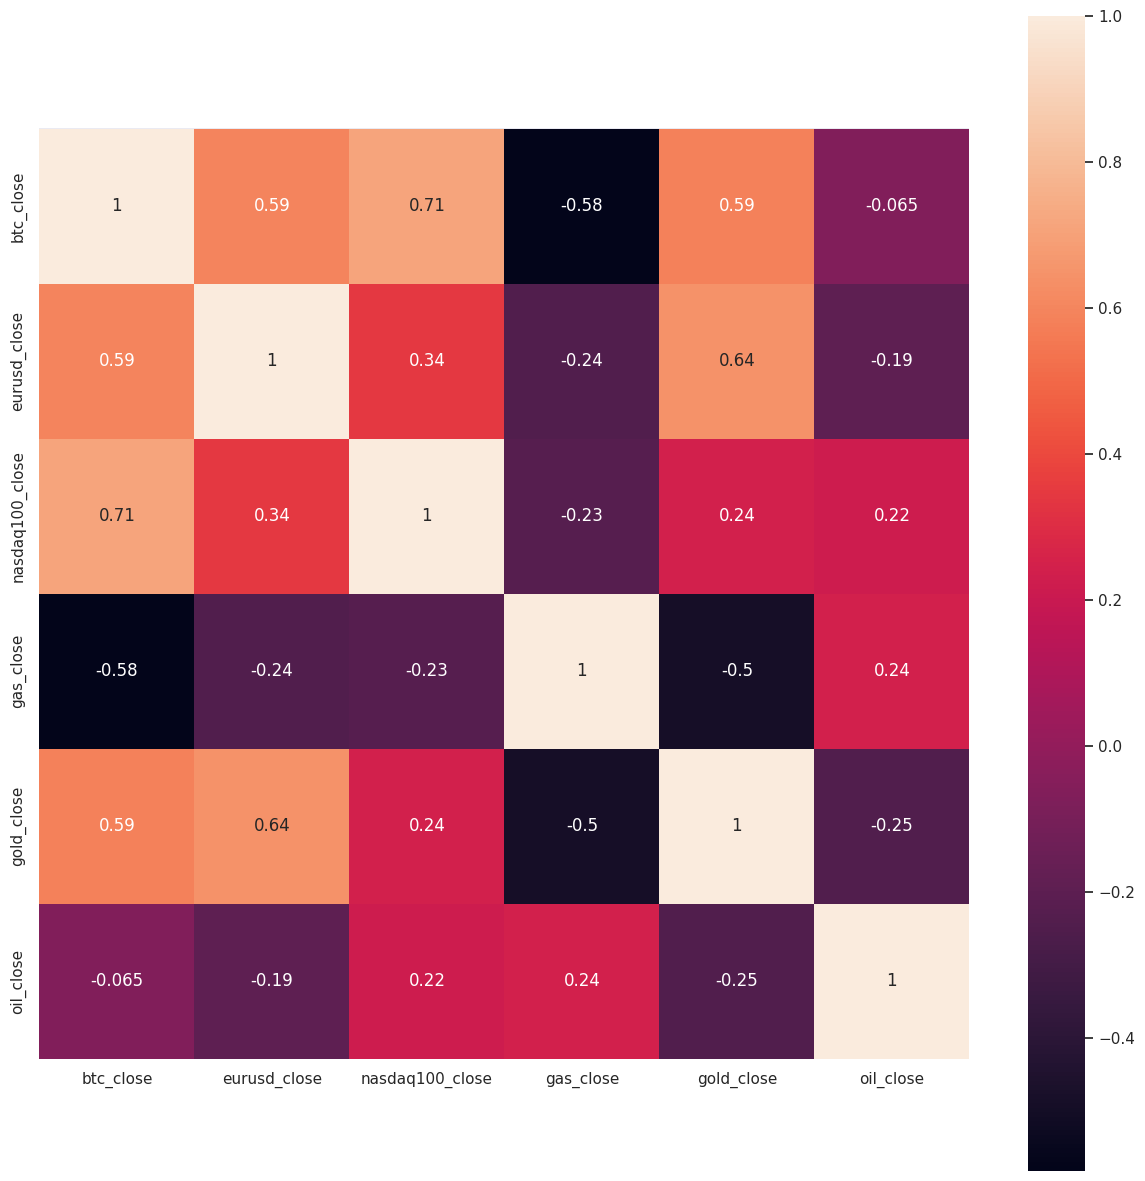

In [61]:
# Let's see for all data
close_columns = ['btc_close','eurusd_close','nasdaq100_close','gas_close','gold_close','oil_close']
norm_corr_past_1month = norm_df[close_columns].corr()
sns.set(rc = {'figure.figsize':(15,15)})
sns.heatmap(norm_corr_past_1month, square=True, annot=True)

<AxesSubplot:>

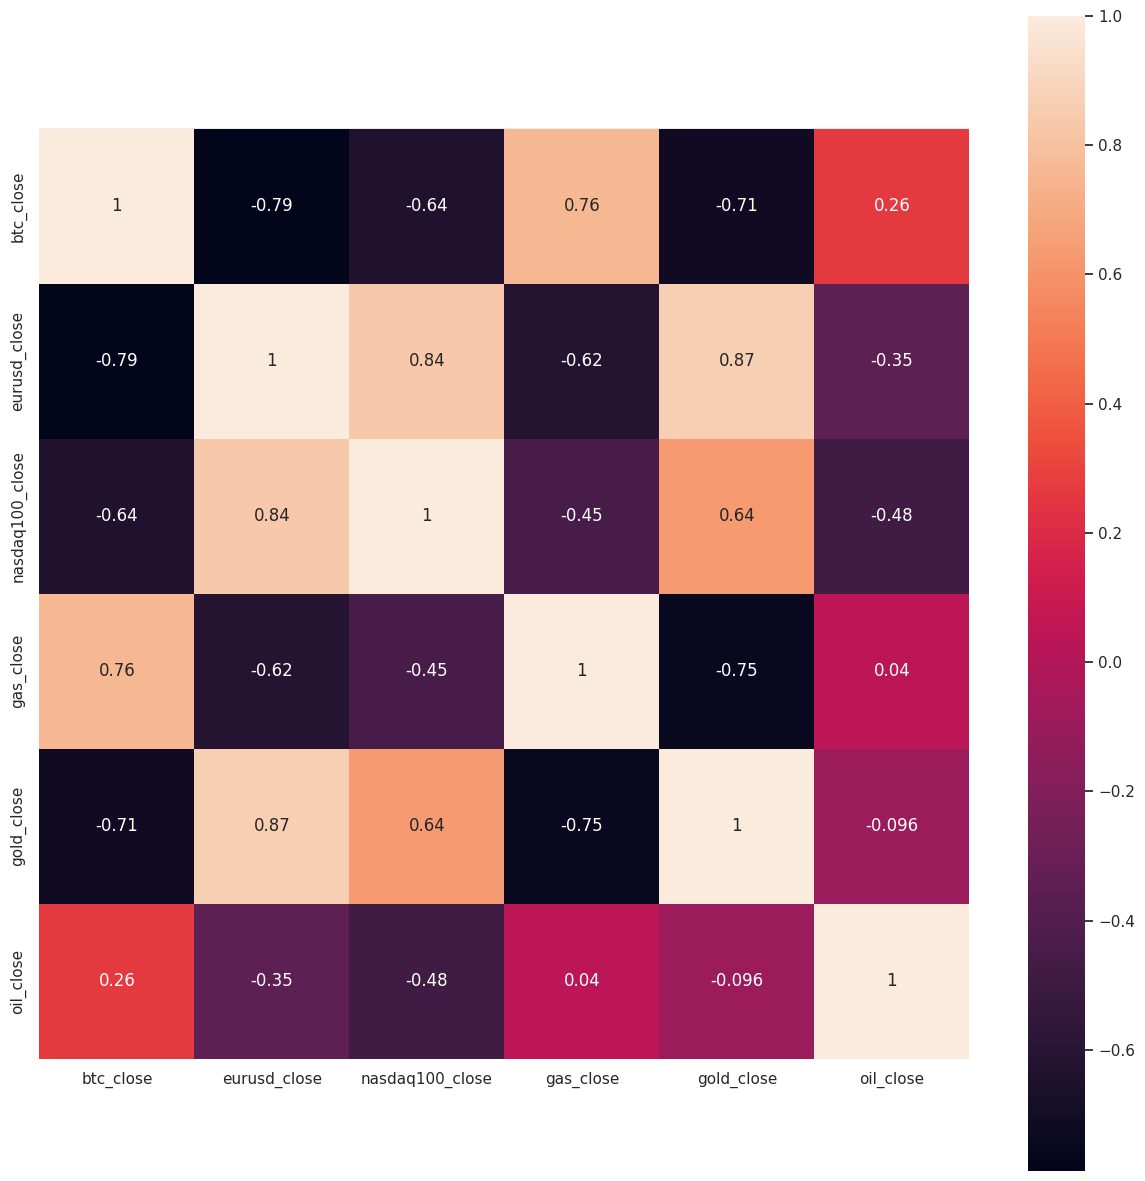

In [62]:
# Let's see only the past 1 month
norm_corr_past_1month = norm_df[close_columns].loc['2023-09-01':].corr()
sns.heatmap(norm_corr_past_1month, square=True, annot=True)

<AxesSubplot:>

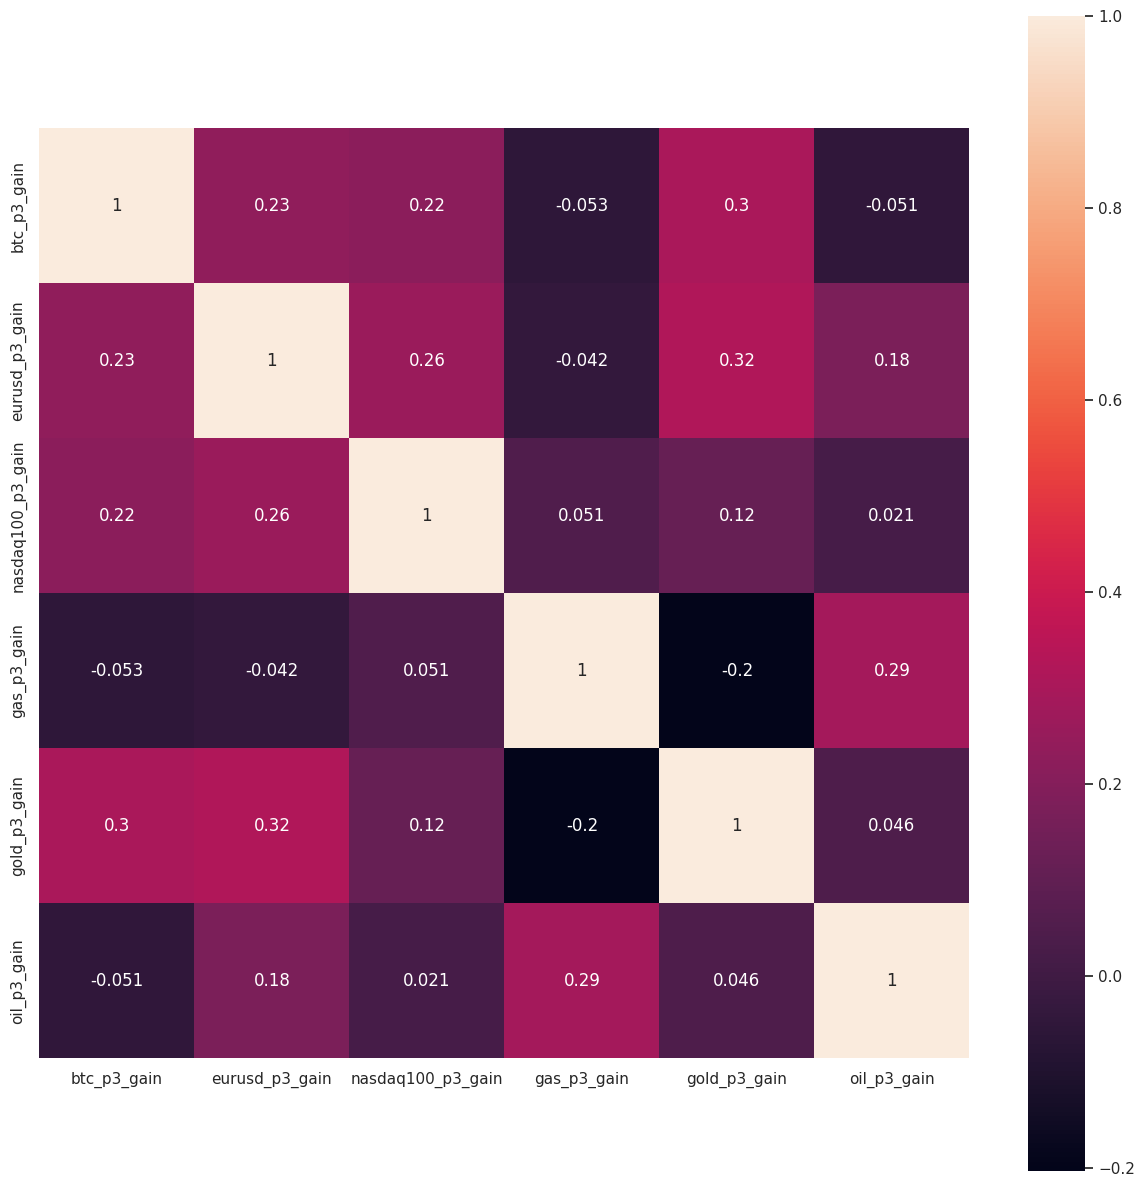

In [63]:
# Let's see for all data
p1_gain_columns = ['btc_p1_gain','eurusd_p1_gain','nasdaq100_p1_gain','gas_p1_gain','gold_p1_gain','oil_p1_gain']
norm_corr_past_1month = norm_df[volume_columns].corr()
sns.heatmap(norm_corr_past_1month, square=True, annot=True)

<AxesSubplot:>

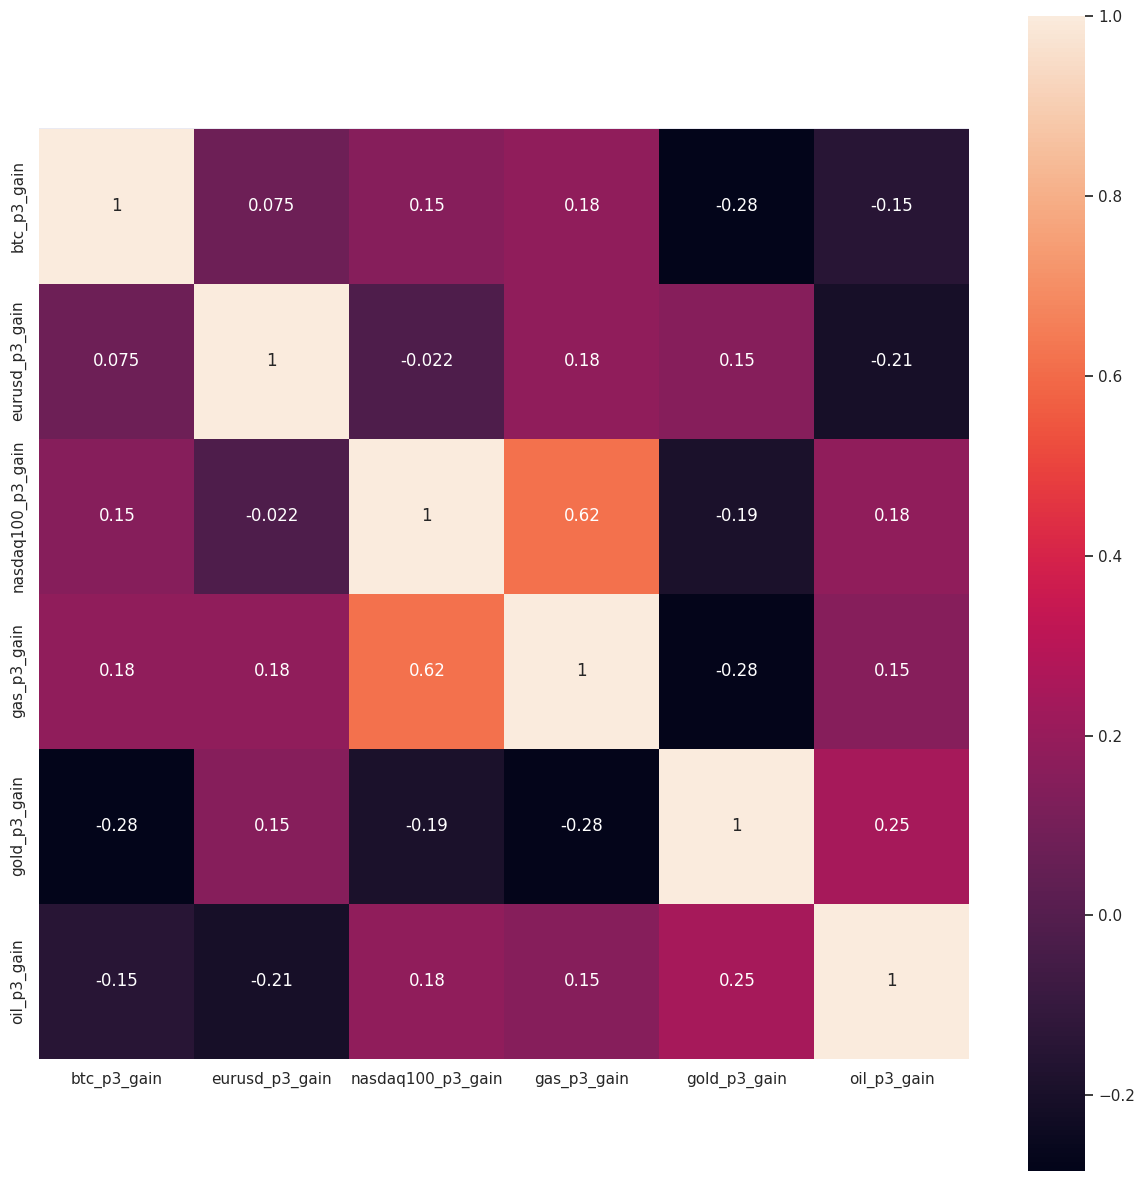

In [64]:
# Let's see only the past 1 month
norm_corr_past_1month = norm_df[volume_columns].loc['2023-09-01':].corr()
sns.heatmap(norm_corr_past_1month, square=True, annot=True)

<AxesSubplot:>

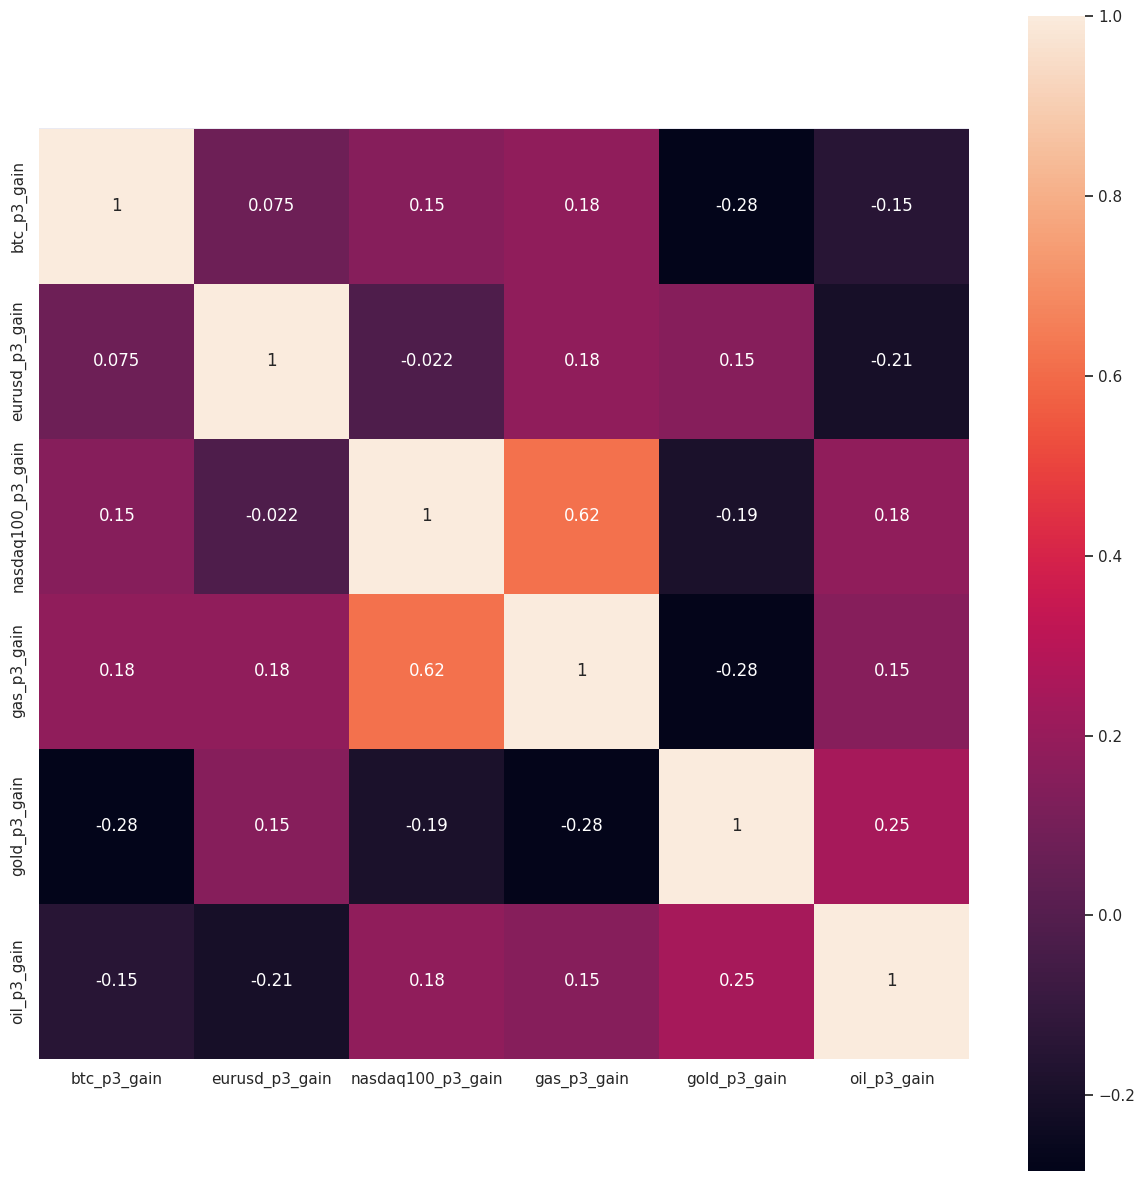

In [65]:
# Let's see only the past 1 month
p3_gain_columns = ['btc_p3_gain','eurusd_p3_gain','nasdaq100_p3_gain','gas_p3_gain','gold_p3_gain','oil_p3_gain']
norm_corr_past_1month = norm_df[p3_gain_columns].loc['2023-09-01':].corr()
sns.heatmap(norm_corr_past_1month, square=True, annot=True)

<AxesSubplot:>

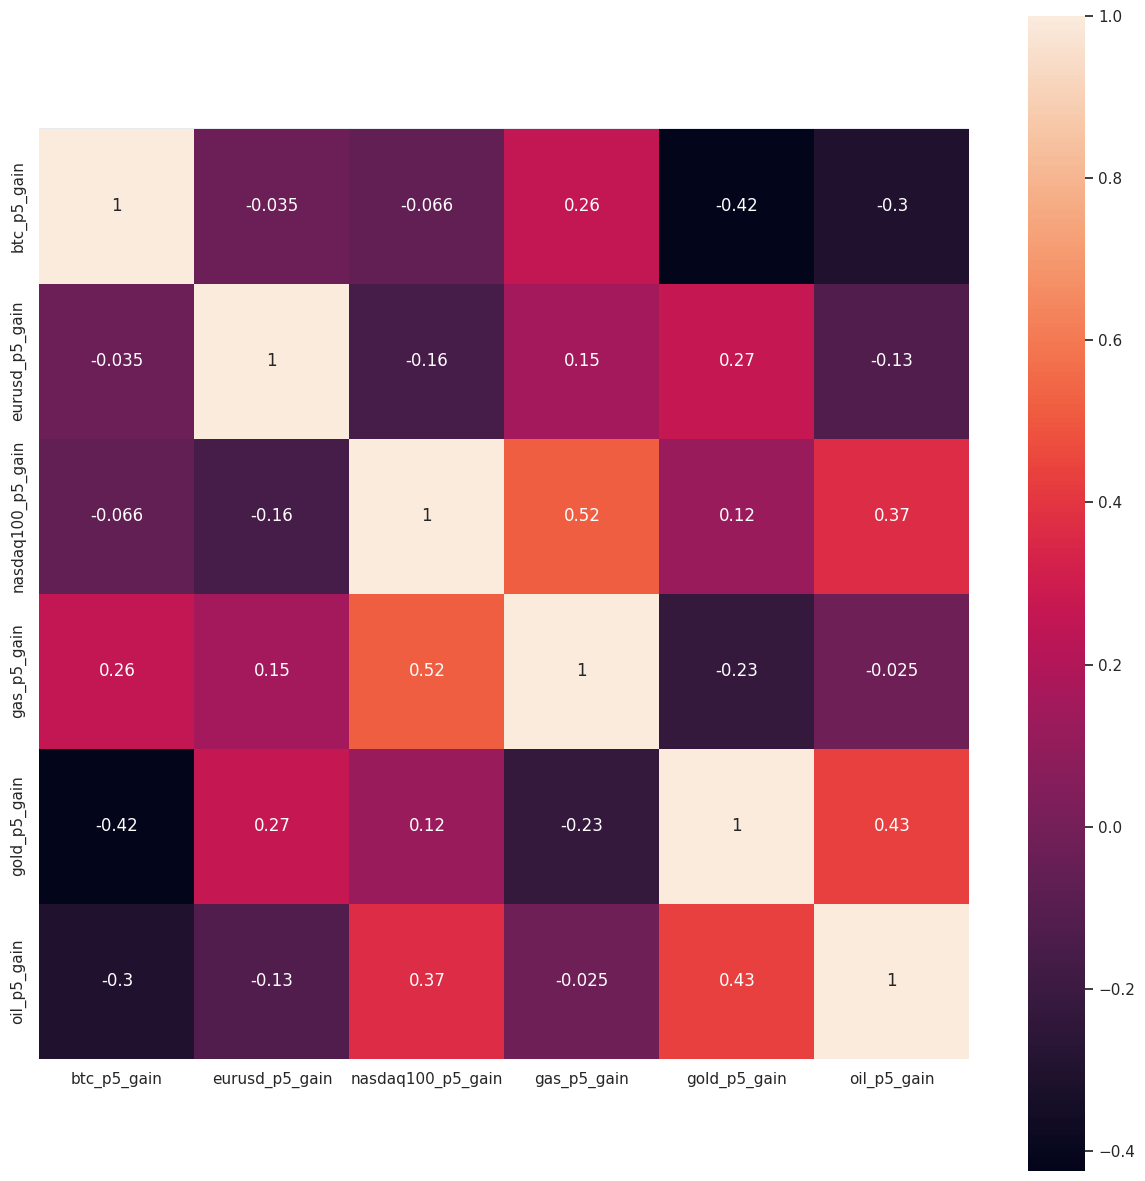

In [66]:
# Let's see only the past 1 month
p5_gain_columns = ['btc_p5_gain','eurusd_p5_gain','nasdaq100_p5_gain','gas_p5_gain','gold_p5_gain','oil_p5_gain']
norm_corr_past_1month = norm_df[p5_gain_columns].loc['2023-09-01':].corr()
sns.heatmap(norm_corr_past_1month, square=True, annot=True)

<AxesSubplot:>

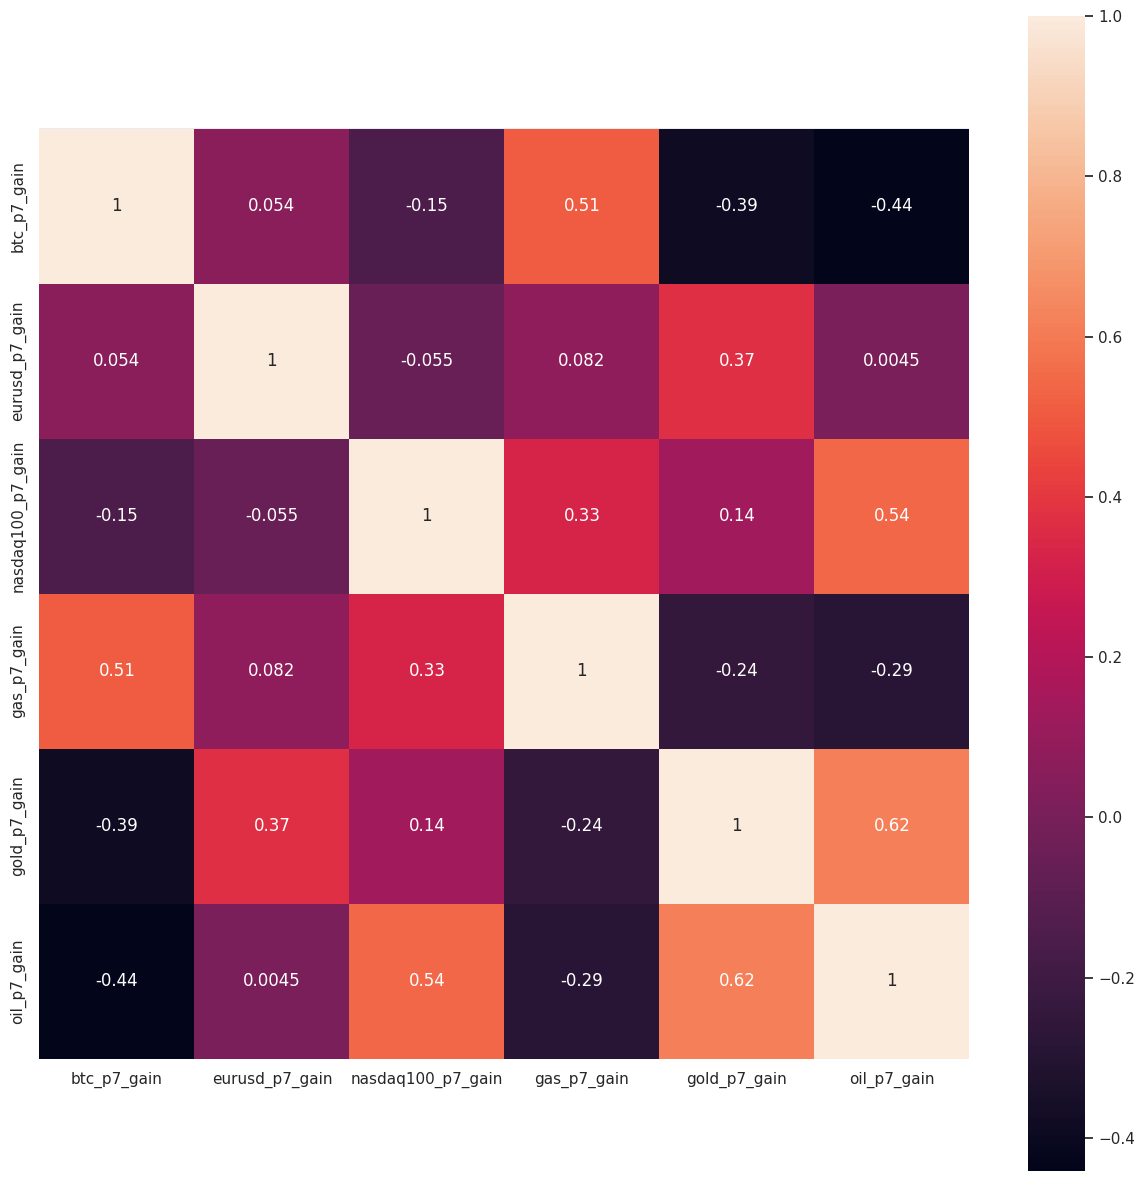

In [67]:
# Let's see only the past 1 month
p7_gain_columns = ['btc_p7_gain','eurusd_p7_gain','nasdaq100_p7_gain','gas_p7_gain','gold_p7_gain','oil_p7_gain']
norm_corr_past_1month = norm_df[p7_gain_columns].loc['2023-09-01':].corr()
sns.heatmap(norm_corr_past_1month, square=True, annot=True)

<AxesSubplot:>

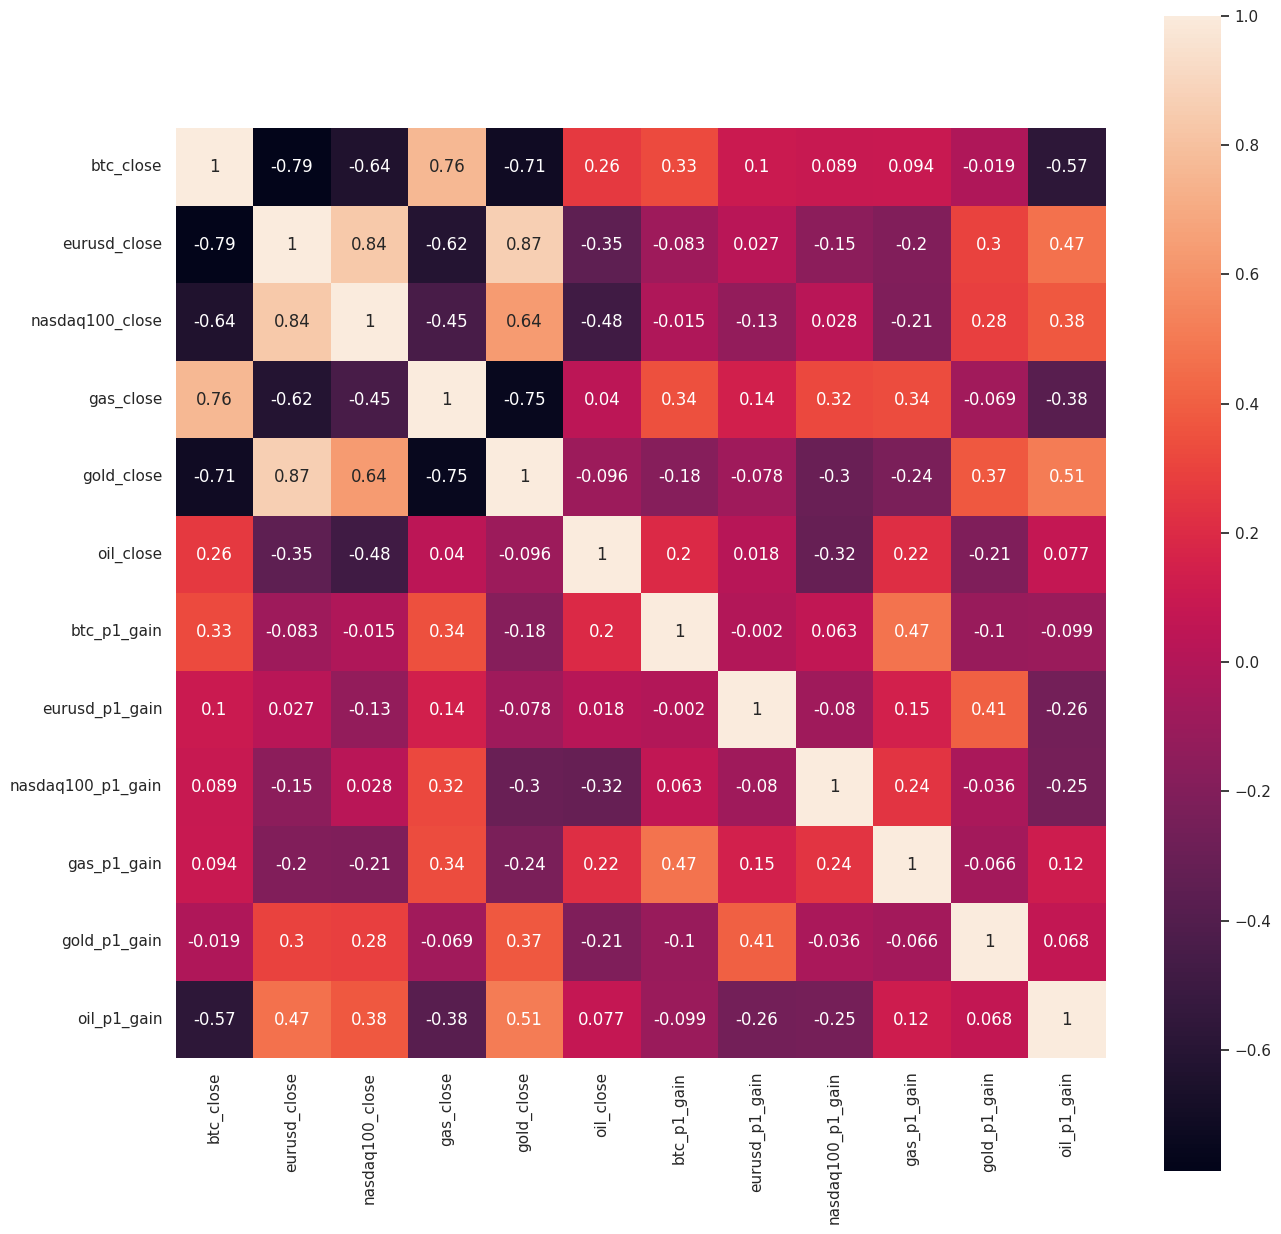

In [68]:
norm_corr_past_1month = norm_df[close_columns+p1_gain_columns].loc['2023-09-01':].corr()
sns.heatmap(norm_corr_past_1month, square=True, annot=True)

<AxesSubplot:>

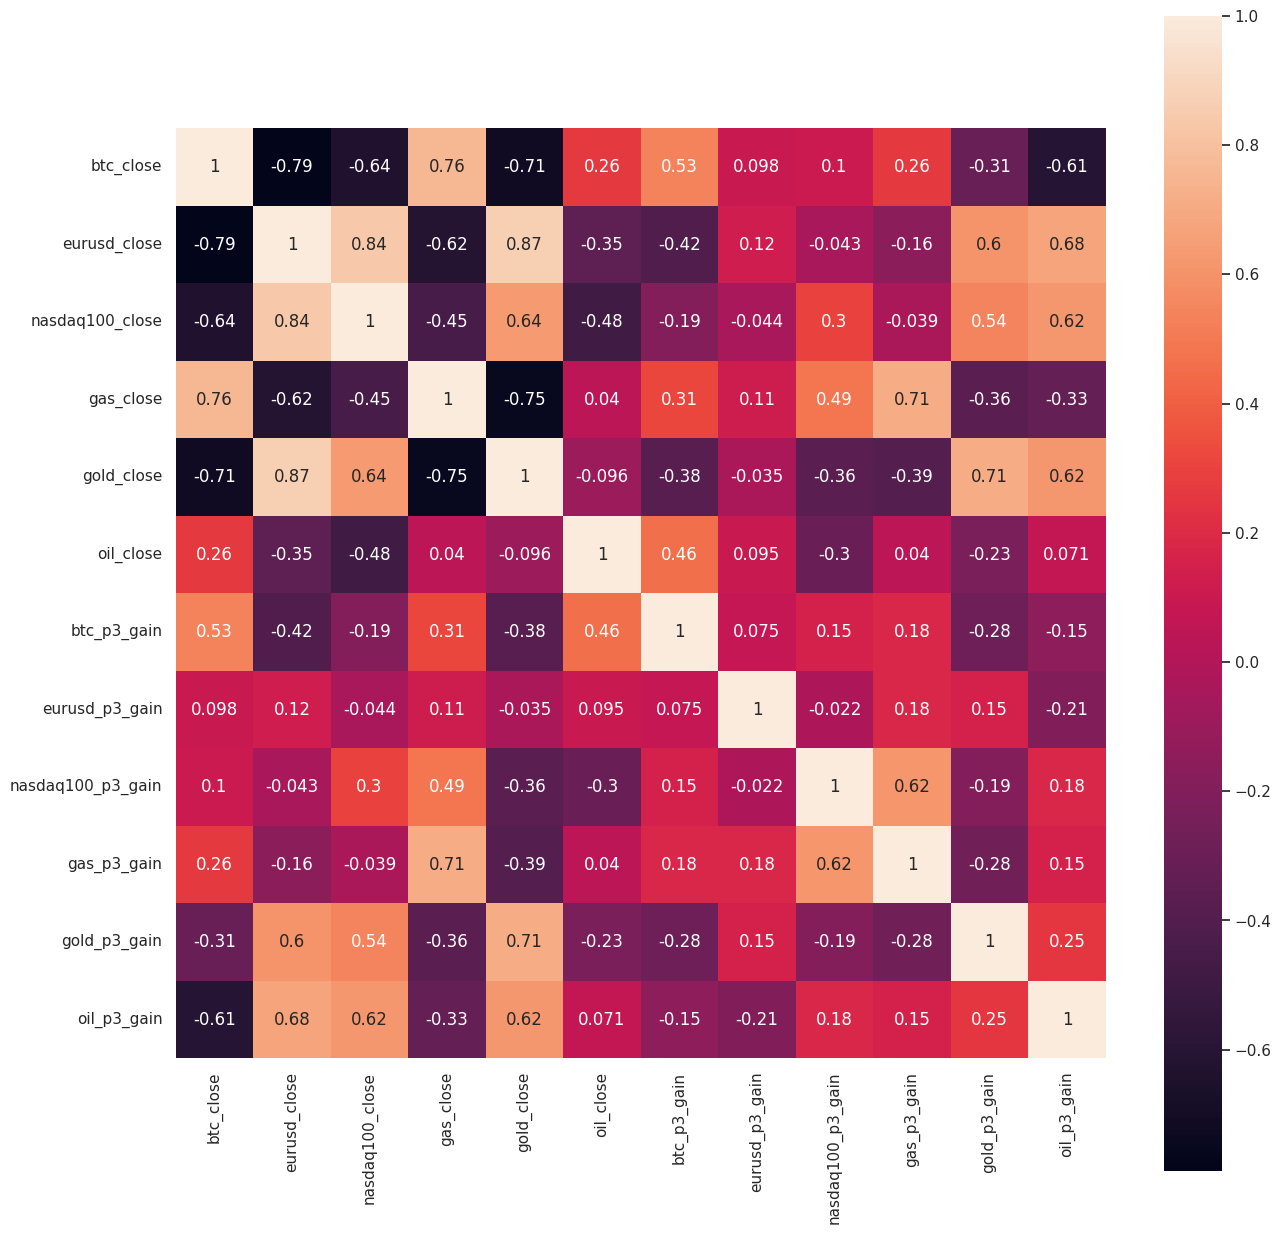

In [69]:
norm_corr_past_1month = norm_df[close_columns+p3_gain_columns].loc['2023-09-01':].corr()
sns.heatmap(norm_corr_past_1month, square=True, annot=True)

<AxesSubplot:>

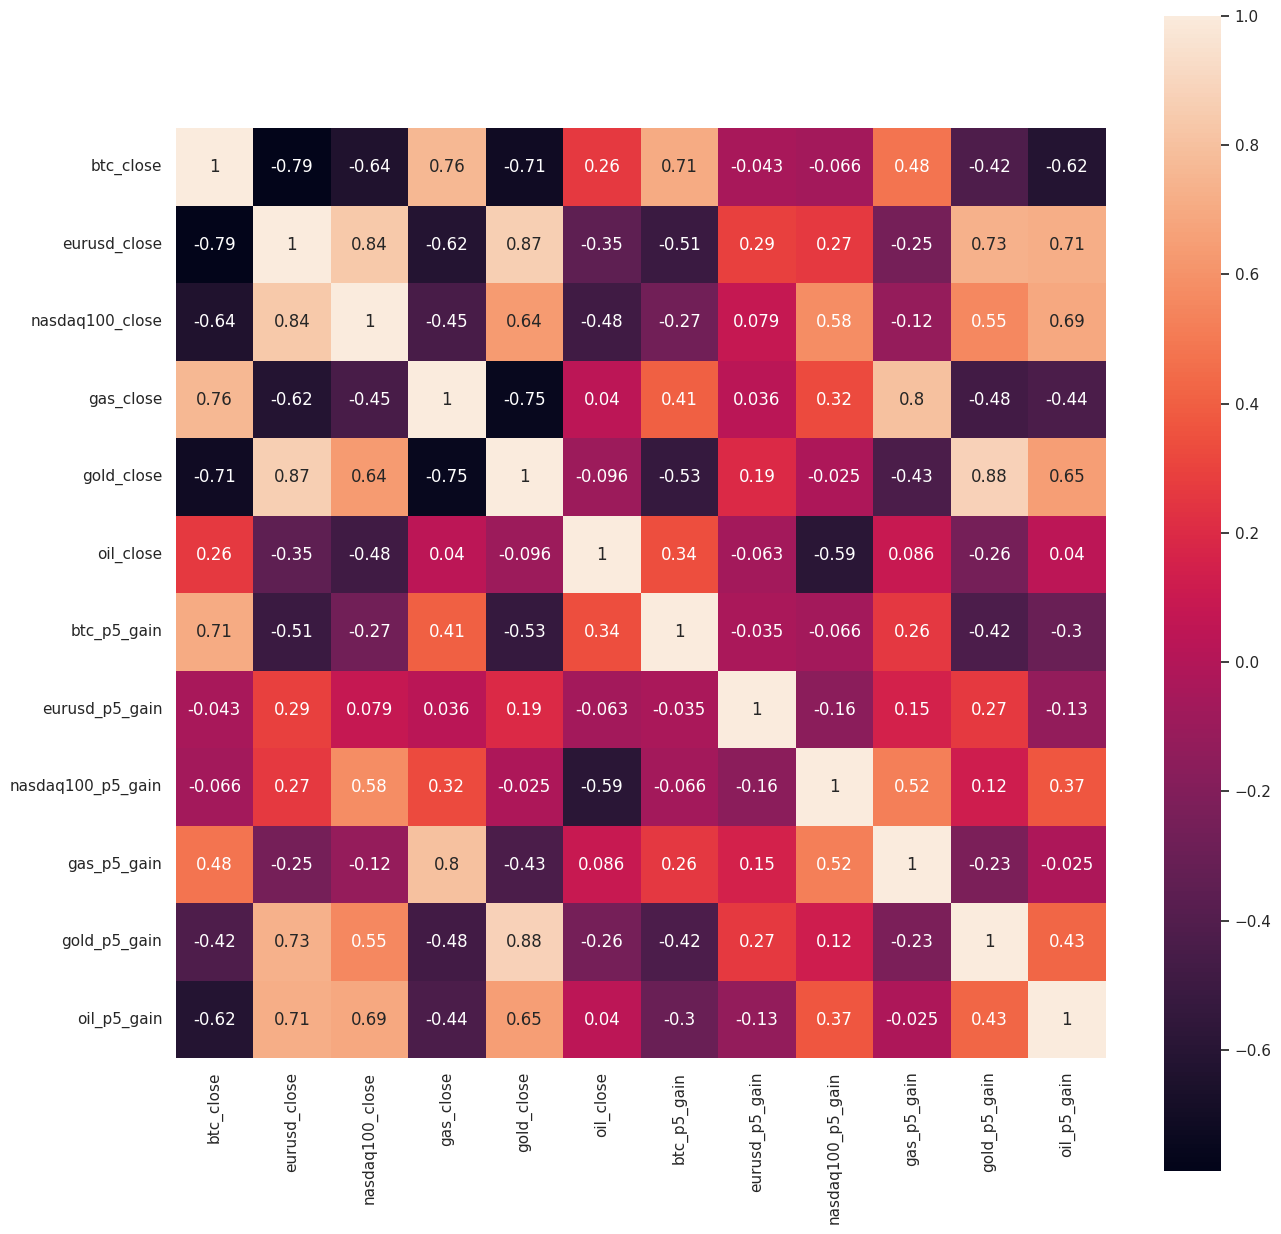

In [70]:
norm_corr_past_1month = norm_df[close_columns+p5_gain_columns].loc['2023-09-01':].corr()
sns.heatmap(norm_corr_past_1month, square=True, annot=True)

<AxesSubplot:>

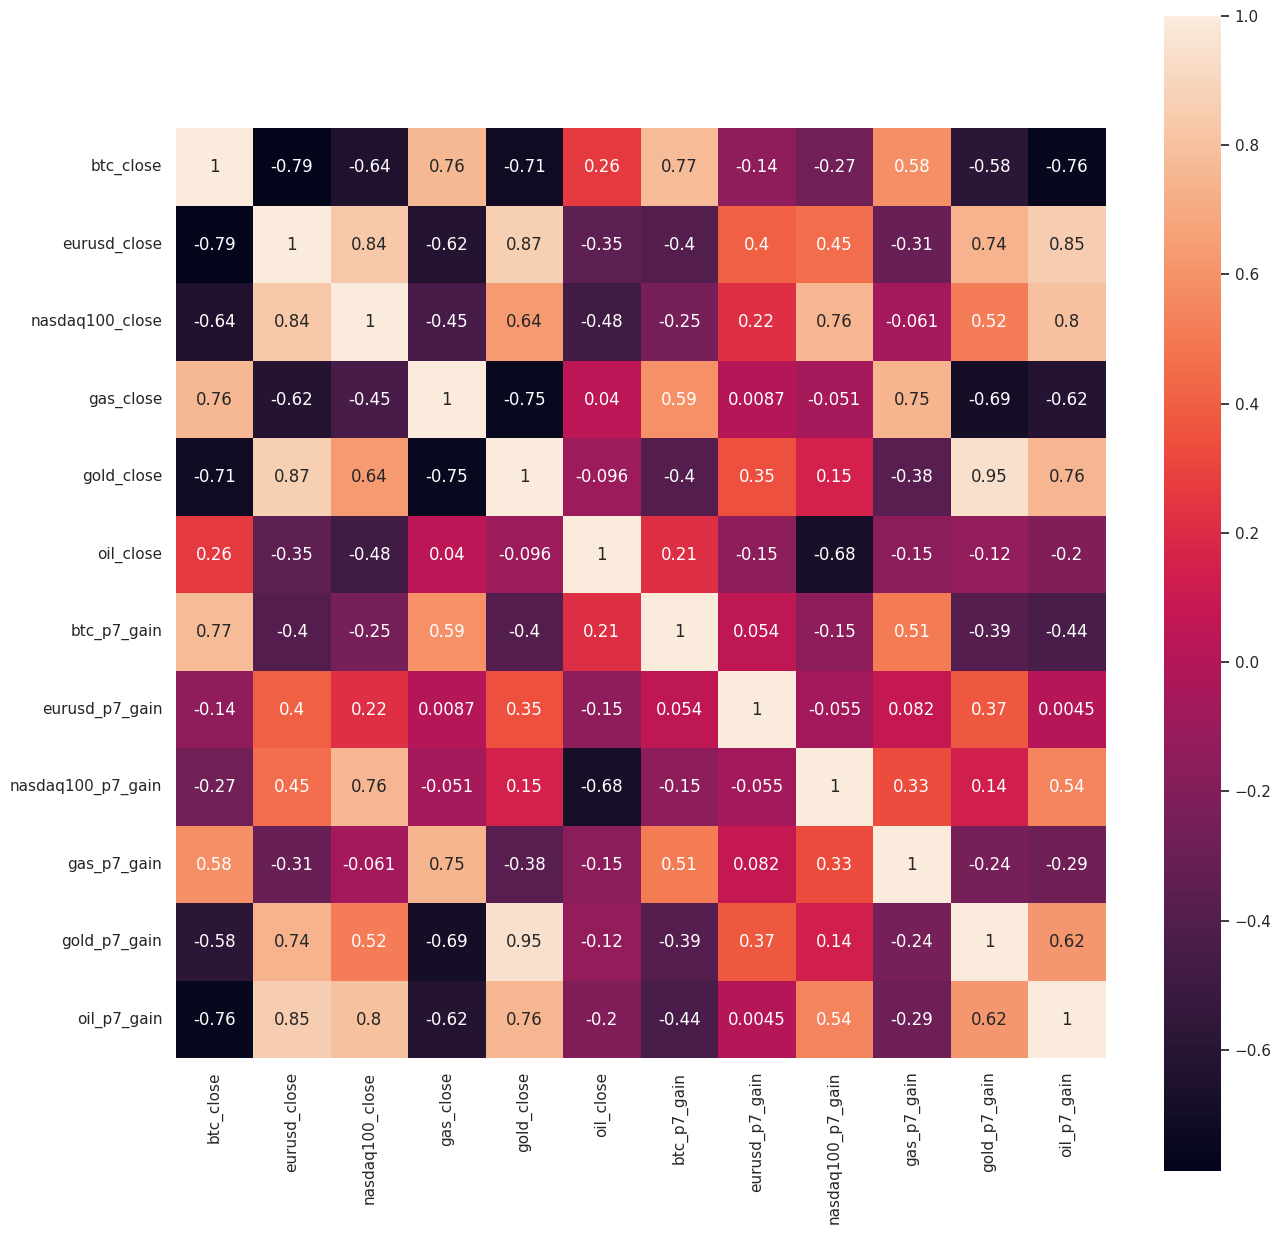

In [71]:
norm_corr_past_1month = norm_df[close_columns+p7_gain_columns].loc['2023-09-01':].corr()
sns.heatmap(norm_corr_past_1month, square=True, annot=True)

<AxesSubplot:>

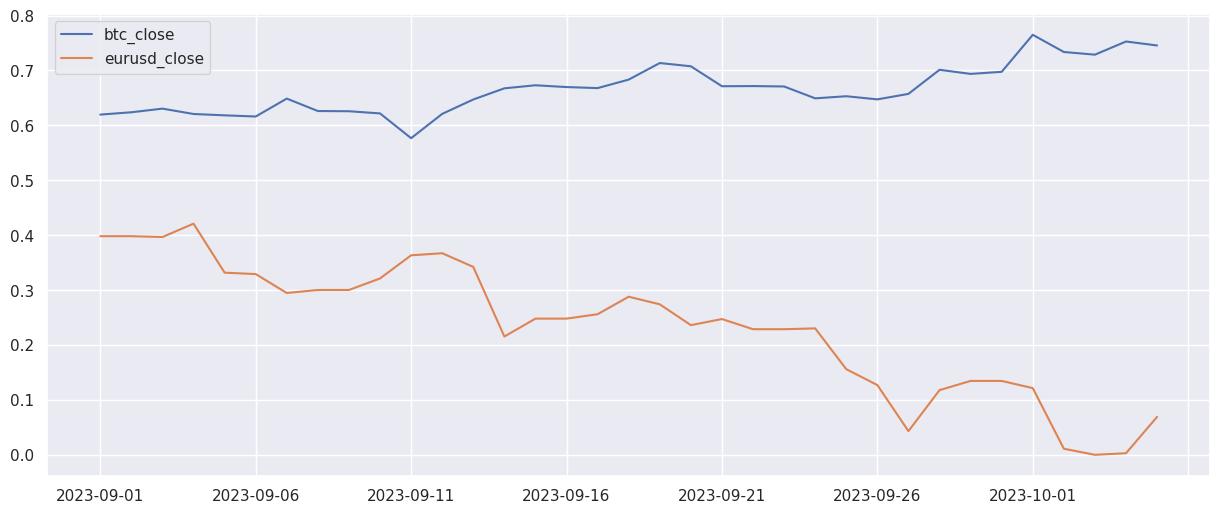

In [73]:
# From the above reuslts, btc_close and eurusd have negative correlation trend for the past 1 month.
norm_df[['btc_close','eurusd_close']].loc['2023-09-01':].plot(figsize=(15,6))